# RAG 평가 시스템


  • 고급 LLM-as-Judge 평가 시스템 구축: Chain of Thought
  평가, Pairwise Comparison, Multi-aspect 평가 등 3가지
  고도화된 평가 방법론을 통해 LLM 답변 품질을 다각도로
  측정하는 커스텀 평가자 시스템 개발

  • 두 QA 시스템 성능 비교: 간단한 답변 생성
  시스템(GPT-3.5)과 상세한 답변 생성 시스템(GPT-4o-mini)을
  복잡한 추론 질문에 대해 비교 평가하며, 각 시스템의 강점과
  약점을 체계적으로 분석

  • 종합적 평가 리포트 생성: LangSmith 연동을 통한 데이터셋
  관리, matplotlib 시각화를 통한 평가 결과 분석,
  CSV/Markdown 형태의 상세 보고서 자동 생성으로 평가 결과를
  종합적으로 문서화

In [1]:
#고급 LLM-as-Judge - Pairwise Comparison & Custom Evaluators


# ========== 1. 패키지 설치 ==========
!pip install langsmith langchain langchain-openai langchain-community --quiet


In [2]:
# 나눔고딕 폰트 설치 및 설정
!apt-get update -qq
!apt-get install fonts-nanum -qq
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm

# 폰트 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontprop = fm.FontProperties(fname=font_path, size=10)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: Failed to fetch http://archive.ubuntu.com/ubuntu/dists/jammy/InRelease  Could not connect to archive.ubuntu.com:80 (91.189.91.81), connection timed out Could not connect to archive.ubuntu.com:80 (91.189.91.82), connection timed out Could not connect to archive.ubuntu.com:80 (91.189.91.83), connection timed out Could not connect to archive.ubuntu.com:80 (185.125.190.81), connection timed out Could not connect to archive.ubuntu.com:80 (185.125.190.82), connection timed out Could not connect to archive.ubuntu.com:80 (185.125.190.83), connection timed out
W: Failed to fetch http://archive.ubuntu.com/ubuntu/dists/jammy-updates/InRelease  Unable to connect to archive.ubuntu.com:80:
W: Failed to fetch http://archive.ubuntu.com/ubuntu/dists/jammy-backports/InRelease  Unable to connect to archive.ubuntu.co

In [3]:

# ========== 2. 환경 설정 ==========
import os
import getpass
import json
from datetime import datetime
from typing import Dict, List, Any, Optional, Tuple
import pandas as pd
import numpy as np

from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, PromptTemplate
from langchain.schema import BaseOutputParser

from langsmith import Client
from langsmith.evaluation import evaluate
from langsmith.schemas import Example, Run

In [ ]:

# OpenAI API 키 설정 (사용자가 입력해야 함)
# from google.colab import userdata
# api_key=userdata.get('api_key')
# os.environ["OPENAI_API_KEY"] = api_key
# api_key2=userdata.get('api_key2')
# os.environ["LANGCHAIN_API_KEY"] = api_key2

from dotenv import load_dotenv

load_dotenv()
# OpenAI API 클라이언트 생성
OPENAPI_KEY = os.getenv("OPENAI_API_KEY")
LangSmith_KEY = os.getenv("LANGCHAIN_API_KEY")

# 2) LangSmith 연동 필수 환경변수
os.environ["LANGCHAIN_TRACING_V2"] = "true"      # 트레이싱 활성화
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"  # 기본값
os.environ["LANGSMITH_PROJECT"]    = "RAG_EV_ex4"                 # 수업용 프로젝트명

✅ 데이터셋 생성 완료: advanced_judge_dataset_20250901_024155

===== Custom LLM Evaluator 평가 시작 =====

평가 중: 회사가 신제품 출시를 앞두고 있는데, 경쟁사 분석과 시장 진입 전략을 어떻게 수립해야 할까...

평가 중: 기후 변화가 글로벌 경제에 미치는 영향과 대응 방안은 무엇인가요?...

평가 중: 인공지능 윤리 문제를 해결하기 위한 기술적, 정책적 접근 방법은?...

===== 평가 결과 분석 =====

📊 시스템별 평균 점수:
Simple System:
  CoT Score: 0.780
  Multi-aspect Score: 0.811

Detailed System:
  CoT Score: 1.000
  Multi-aspect Score: 0.967

🥊 Pairwise Comparison 결과:
  Detailed: 2 (66.7%)
  Tie: 1 (33.3%)
  평균 확신도: 0.733


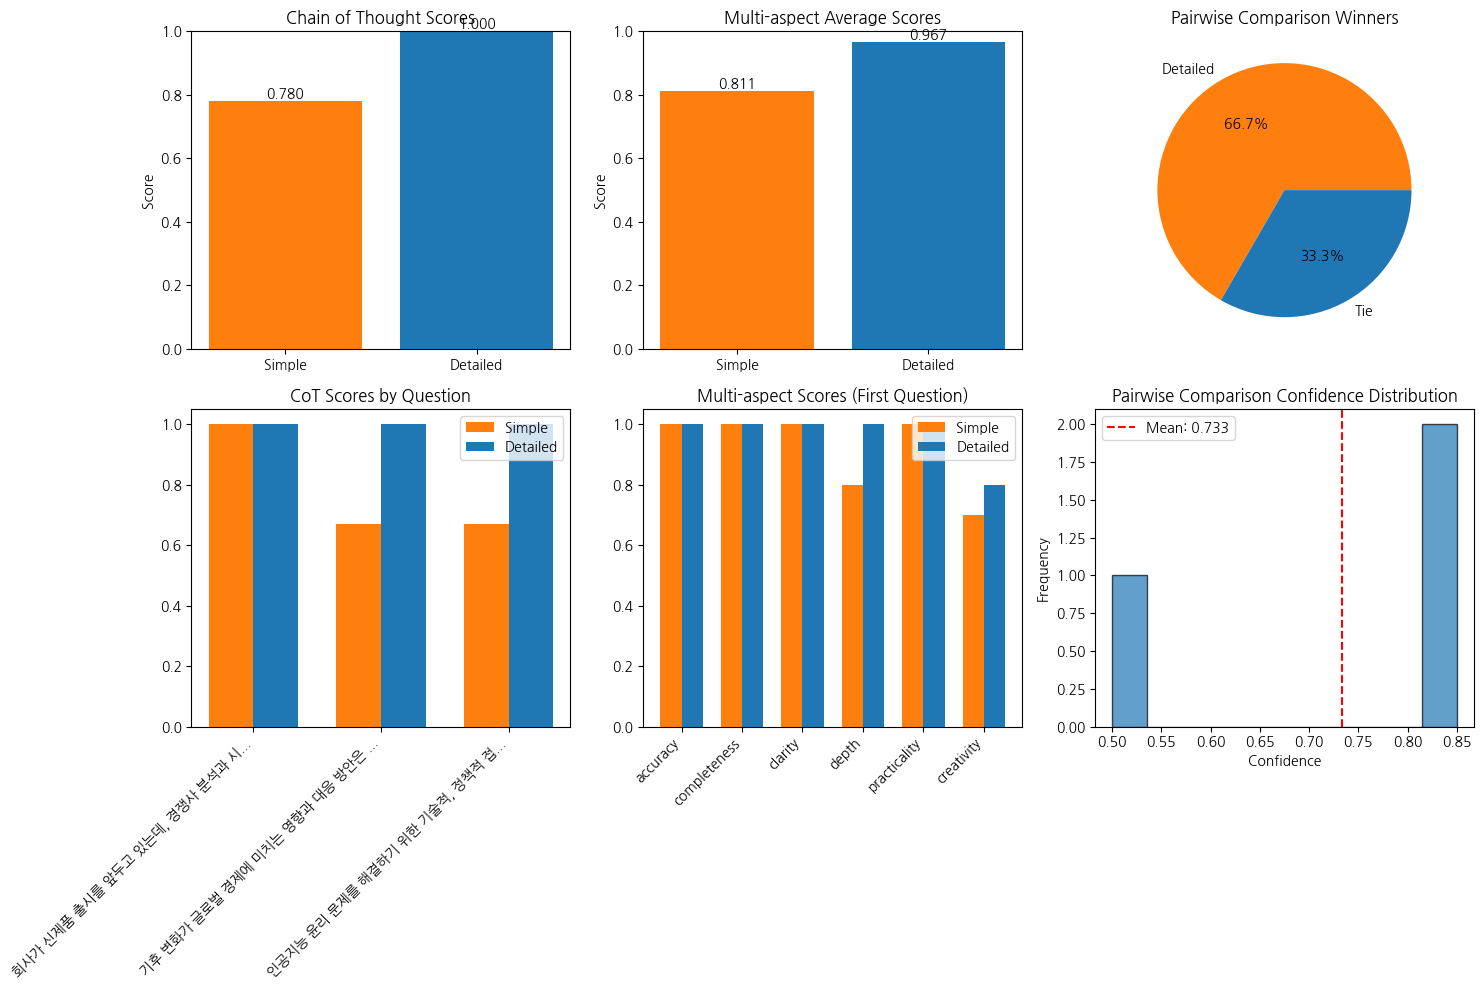


===== 상세 평가 피드백 (첫 번째 예제) =====

질문: 회사가 신제품 출시를 앞두고 있는데, 경쟁사 분석과 시장 진입 전략을 어떻게 수립해야 할까요?...

[Chain of Thought 평가]
Simple System:
  completeness: 1.00
  practicality: 1.00
  structure: 1.00

Detailed System:
  completeness: 1.00
  practicality: 1.00
  structure: 1.00

[Pairwise 비교]
승자: B
확신도: 0.85
근거: 답변 B는 경쟁사 분석과 시장 진입 전략에 대한 체계적이고 구체적인 설명을 제공하며, 실용적인 조언과 예시를 통해 독자가 이해하기 쉽게 구성되어 있습니다. 반면, 답변 A는 간결하지만 구체적인 내용이나 예시가 부족하여 실용성이 떨어집니다. 따라서 B가 더 유용하고 완성도 높은 답변으로 평가됩니다....

===== Criteria별 성능 분석 =====

Criteria별 평균 점수:
depth:
  Simple: 0.500
  Detailed: 1.000
  차이: +0.500
structure:
  Simple: 1.000
  Detailed: 1.000
  차이: +0.000
practicality:
  Simple: 1.000
  Detailed: 1.000
  차이: +0.000
innovation:
  Simple: 0.000
  Detailed: 1.000
  차이: +1.000
technical_accuracy:
  Simple: 1.000
  Detailed: 1.000
  차이: +0.000
policy_understanding:
  Simple: 1.000
  Detailed: 1.000
  차이: +0.000
solutions:
  Simple: 1.000
  Detailed: 1.000
  차이: +0.000
balance:
  Simple: 0.500
  Detailed: 1.000
  차이: +0.

In [5]:


# ========== 3. 고급 평가 시나리오 데이터셋 ==========
# 복잡한 추론이 필요한 질문들
advanced_examples = [
    {
        "question": "회사가 신제품 출시를 앞두고 있는데, 경쟁사 분석과 시장 진입 전략을 어떻게 수립해야 할까요?",
        "reference_answer": "경쟁사 분석은 SWOT 분석, 포터의 5 Forces 모델을 활용하고, 시장 진입 전략은 차별화, 비용 우위, 틈새시장 공략 중 선택해야 합니다. 타겟 고객 정의, 가격 전략, 유통 채널 선정도 중요합니다.",
        "criteria": {
            "completeness": "답변이 경쟁사 분석과 시장 진입 전략을 모두 다루는가?",
            "practicality": "제시된 전략이 실무에 적용 가능한가?",
            "structure": "답변이 체계적으로 구성되어 있는가?"
        }
    },
    {
        "question": "기후 변화가 글로벌 경제에 미치는 영향과 대응 방안은 무엇인가요?",
        "reference_answer": "기후 변화는 농업 생산성 감소, 자연재해 증가로 인한 경제적 손실, 에너지 전환 비용 등의 영향을 미칩니다. 대응 방안으로는 탄소세 도입, 녹색 기술 투자, 국제 협력 강화가 필요합니다.",
        "criteria": {
            "depth": "경제적 영향을 다각도로 분석했는가?",
            "solutions": "실현 가능한 대응 방안을 제시했는가?",
            "balance": "영향과 대응 방안을 균형있게 다뤘는가?"
        }
    },
    {
        "question": "인공지능 윤리 문제를 해결하기 위한 기술적, 정책적 접근 방법은?",
        "reference_answer": "기술적으로는 설명가능한 AI, 편향 제거 알고리즘, 프라이버시 보호 기술이 필요하고, 정책적으로는 AI 윤리 가이드라인 제정, 규제 프레임워크 구축, 국제 표준 수립이 필요합니다.",
        "criteria": {
            "technical_accuracy": "기술적 접근이 정확한가?",
            "policy_understanding": "정책적 고려사항을 이해하고 있는가?",
            "innovation": "창의적인 해결책을 제시했는가?"
        }
    }
]

# ========== 4. Custom Evaluator 클래스 ==========
class CustomLLMEvaluator:
    """커스텀 LLM 평가자"""

    def __init__(self, llm_model="gpt-4o-mini"):
        self.llm = ChatOpenAI(model=llm_model, temperature=0)

    def evaluate_with_cot(self, question: str, answer: str, criteria: Dict[str, str]) -> Dict[str, Any]:
        """Chain of Thought를 사용한 평가"""

        cot_prompt = ChatPromptTemplate.from_template("""
당신은 전문 평가자입니다. 다음 질문과 답변을 주어진 기준에 따라 평가하세요.

질문: {question}

답변: {answer}

평가 기준:
{criteria_text}

각 기준에 대해 단계별로 평가하세요:
1. 먼저 각 기준이 요구하는 것을 명확히 파악
2. 답변에서 해당 기준과 관련된 부분 식별
3. 0-1 점수로 평가 (0: 전혀 충족하지 못함, 1: 완벽히 충족)
4. 평가 근거 제시

다음 JSON 형식으로 출력하세요:
{{
    "scores": {{기준명: 점수, ...}},
    "reasoning": {{기준명: "평가 근거", ...}},
    "overall_score": 전체 평균 점수,
    "summary": "전체 평가 요약"
}}
""")

        criteria_text = "\n".join([f"- {name}: {desc}" for name, desc in criteria.items()])

        response = self.llm.invoke(
            cot_prompt.format(
                question=question,
                answer=answer,
                criteria_text=criteria_text
            )
        )

        try:
            return json.loads(response.content)
        except:
            # JSON 파싱 실패 시 기본값 반환
            return {
                "scores": {name: 0.5 for name in criteria.keys()},
                "reasoning": {name: "평가 실패" for name in criteria.keys()},
                "overall_score": 0.5,
                "summary": "JSON 파싱 실패"
            }

    def pairwise_comparison(
        self,
        question: str,
        answer_a: str,
        answer_b: str,
        criteria: str = "overall quality"
    ) -> Dict[str, Any]:
        """두 답변을 비교 평가"""

        pairwise_prompt = ChatPromptTemplate.from_template("""
다음 질문에 대한 두 답변을 비교 평가하세요.

질문: {question}

답변 A:
{answer_a}

답변 B:
{answer_b}

평가 기준: {criteria}

두 답변을 다음 관점에서 비교하세요:
1. 정확성과 사실성
2. 완성도와 포괄성
3. 명확성과 구조
4. 실용성과 유용성

다음 JSON 형식으로 출력:
{{
    "winner": "A" 또는 "B" 또는 "tie",
    "confidence": 0-1 사이의 확신도,
    "comparison": {{
        "answer_a_strengths": ["장점1", "장점2"],
        "answer_a_weaknesses": ["단점1", "단점2"],
        "answer_b_strengths": ["장점1", "장점2"],
        "answer_b_weaknesses": ["단점1", "단점2"]
    }},
    "reasoning": "비교 평가 근거"
}}
""")

        response = self.llm.invoke(
            pairwise_prompt.format(
                question=question,
                answer_a=answer_a,
                answer_b=answer_b,
                criteria=criteria
            )
        )

        try:
            return json.loads(response.content)
        except:
            return {
                "winner": "tie",
                "confidence": 0.5,
                "comparison": {},
                "reasoning": "평가 실패"
            }

    def multi_aspect_evaluation(
        self,
        question: str,
        answer: str,
        reference: Optional[str] = None
    ) -> Dict[str, float]:
        """다차원 평가"""

        aspects = {
            "accuracy": "답변의 사실적 정확성",
            "completeness": "질문의 모든 부분을 다루는 완성도",
            "clarity": "명확하고 이해하기 쉬운 표현",
            "depth": "주제에 대한 깊이 있는 분석",
            "practicality": "실제 적용 가능한 내용",
            "creativity": "창의적이고 독창적인 접근"
        }

        multi_prompt = ChatPromptTemplate.from_template("""
질문: {question}

답변: {answer}

{reference_text}

다음 각 측면에서 답변을 0-1점으로 평가하세요:
{aspects_text}

JSON 형식으로 점수만 출력:
{{"accuracy": 0.X, "completeness": 0.X, ...}}
""")

        reference_text = f"참고 답안: {reference}" if reference else ""
        aspects_text = "\n".join([f"- {name}: {desc}" for name, desc in aspects.items()])

        response = self.llm.invoke(
            multi_prompt.format(
                question=question,
                answer=answer,
                reference_text=reference_text,
                aspects_text=aspects_text
            )
        )

        try:
            scores = json.loads(response.content)
            return {k: float(v) for k, v in scores.items()}
        except:
            return {k: 0.5 for k in aspects.keys()}

# ========== 5. 평가 대상 시스템들 ==========
# 시스템 A: 간단한 답변
def simple_qa_system(inputs: Dict[str, Any]) -> Dict[str, Any]:
    """간단한 답변 생성 시스템"""
    llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)
    prompt = "질문: {question}\n\n간단명료하게 답변하세요."
    response = llm.invoke(prompt.format(question=inputs["question"]))
    return {"answer": response.content}

# 시스템 B: 상세한 답변
def detailed_qa_system(inputs: Dict[str, Any]) -> Dict[str, Any]:
    """상세한 답변 생성 시스템"""
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)
    prompt = """질문: {question}

체계적이고 상세한 답변을 제공하세요. 다음을 포함하세요:
1. 핵심 개념 설명
2. 구체적인 예시
3. 실용적인 조언"""

    response = llm.invoke(prompt.format(question=inputs["question"]))
    return {"answer": response.content}

# ========== 6. LangSmith 데이터셋 생성 ==========
client = Client()

dataset_name = f"advanced_judge_dataset_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="고급 LLM-as-Judge 평가를 위한 데이터셋"
)

for example in advanced_examples:
    client.create_example(
        dataset_id=dataset.id,
        inputs={"question": example["question"]},
        outputs={"reference_answer": example["reference_answer"]},
        metadata={"criteria": example["criteria"]}
    )

print(f"✅ 데이터셋 생성 완료: {dataset_name}")

# ========== 7. Custom Evaluator를 사용한 평가 ==========
print("\n===== Custom LLM Evaluator 평가 시작 =====")

evaluator = CustomLLMEvaluator()
evaluation_results = []

# 두 시스템으로 답변 생성 및 평가
for example in advanced_examples:
    question = example["question"]

    # 두 시스템의 답변 생성
    simple_answer = simple_qa_system({"question": question})["answer"]
    detailed_answer = detailed_qa_system({"question": question})["answer"]

    print(f"\n평가 중: {question[:50]}...")

    # 1. Chain of Thought 평가
    simple_cot = evaluator.evaluate_with_cot(question, simple_answer, example["criteria"])
    detailed_cot = evaluator.evaluate_with_cot(question, detailed_answer, example["criteria"])

    # 2. Pairwise 비교
    pairwise_result = evaluator.pairwise_comparison(
        question,
        simple_answer,
        detailed_answer,
        "전체적인 품질과 유용성"
    )

    # 3. Multi-aspect 평가
    simple_multi = evaluator.multi_aspect_evaluation(
        question,
        simple_answer,
        example["reference_answer"]
    )
    detailed_multi = evaluator.multi_aspect_evaluation(
        question,
        detailed_answer,
        example["reference_answer"]
    )

    evaluation_results.append({
        "question": question,
        "simple_answer": simple_answer,
        "detailed_answer": detailed_answer,
        "simple_cot_score": simple_cot.get("overall_score", 0),
        "detailed_cot_score": detailed_cot.get("overall_score", 0),
        "pairwise_winner": pairwise_result.get("winner", "tie"),
        "pairwise_confidence": pairwise_result.get("confidence", 0),
        "simple_multi_avg": np.mean(list(simple_multi.values())),
        "detailed_multi_avg": np.mean(list(detailed_multi.values())),
        "simple_cot_details": simple_cot,
        "detailed_cot_details": detailed_cot,
        "pairwise_details": pairwise_result,
        "simple_multi_details": simple_multi,
        "detailed_multi_details": detailed_multi
    })

# DataFrame 생성
results_df = pd.DataFrame(evaluation_results)

# ========== 8. 결과 분석 및 시각화 ==========
print("\n===== 평가 결과 분석 =====")

# 전체 점수 비교
print("\n📊 시스템별 평균 점수:")
print(f"Simple System:")
print(f"  CoT Score: {results_df['simple_cot_score'].mean():.3f}")
print(f"  Multi-aspect Score: {results_df['simple_multi_avg'].mean():.3f}")

print(f"\nDetailed System:")
print(f"  CoT Score: {results_df['detailed_cot_score'].mean():.3f}")
print(f"  Multi-aspect Score: {results_df['detailed_multi_avg'].mean():.3f}")

# Pairwise 결과
print("\n🥊 Pairwise Comparison 결과:")
winner_counts = results_df['pairwise_winner'].value_counts()
for winner, count in winner_counts.items():
    winner_name = "Simple" if winner == "A" else "Detailed" if winner == "B" else "Tie"
    print(f"  {winner_name}: {count} ({count/len(results_df)*100:.1f}%)")

avg_confidence = results_df['pairwise_confidence'].mean()
print(f"  평균 확신도: {avg_confidence:.3f}")

# ========== 9. 상세 분석 시각화 ==========


fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. CoT 점수 비교
systems = ['Simple', 'Detailed']
cot_scores = [results_df['simple_cot_score'].mean(), results_df['detailed_cot_score'].mean()]
axes[0, 0].bar(systems, cot_scores, color=['#ff7f0e', '#1f77b4'])
axes[0, 0].set_title('Chain of Thought Scores')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_ylim(0, 1)
for i, v in enumerate(cot_scores):
    axes[0, 0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 2. Multi-aspect 점수 비교
multi_scores = [results_df['simple_multi_avg'].mean(), results_df['detailed_multi_avg'].mean()]
axes[0, 1].bar(systems, multi_scores, color=['#ff7f0e', '#1f77b4'])
axes[0, 1].set_title('Multi-aspect Average Scores')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim(0, 1)
for i, v in enumerate(multi_scores):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')

# 3. Pairwise 결과
winner_labels = []
winner_values = []
for winner, count in winner_counts.items():
    winner_name = "Simple" if winner == "A" else "Detailed" if winner == "B" else "Tie"
    winner_labels.append(winner_name)
    winner_values.append(count)

axes[0, 2].pie(winner_values, labels=winner_labels, autopct='%1.1f%%',
               colors=['#ff7f0e', '#1f77b4', '#2ca02c'])
axes[0, 2].set_title('Pairwise Comparison Winners')

# 4. 각 질문별 점수 비교
questions_short = [q[:30] + "..." for q in results_df['question']]
x = np.arange(len(questions_short))
width = 0.35

axes[1, 0].bar(x - width/2, results_df['simple_cot_score'], width, label='Simple', color='#ff7f0e')
axes[1, 0].bar(x + width/2, results_df['detailed_cot_score'], width, label='Detailed', color='#1f77b4')
axes[1, 0].set_title('CoT Scores by Question')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(questions_short, rotation=45, ha='right')
axes[1, 0].legend()

# 5. Multi-aspect 세부 점수 (첫 번째 예제)
if evaluation_results:
    first_result = evaluation_results[0]
    aspects = list(first_result['simple_multi_details'].keys())
    simple_values = list(first_result['simple_multi_details'].values())
    detailed_values = list(first_result['detailed_multi_details'].values())

    x2 = np.arange(len(aspects))
    axes[1, 1].bar(x2 - width/2, simple_values, width, label='Simple', color='#ff7f0e')
    axes[1, 1].bar(x2 + width/2, detailed_values, width, label='Detailed', color='#1f77b4')
    axes[1, 1].set_title('Multi-aspect Scores (First Question)')
    axes[1, 1].set_xticks(x2)
    axes[1, 1].set_xticklabels(aspects, rotation=45, ha='right')
    axes[1, 1].legend()

# 6. Confidence 분포
axes[1, 2].hist(results_df['pairwise_confidence'], bins=10, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Pairwise Comparison Confidence Distribution')
axes[1, 2].set_xlabel('Confidence')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(avg_confidence, color='red', linestyle='--', label=f'Mean: {avg_confidence:.3f}')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# ========== 10. 상세 피드백 출력 ==========
print("\n===== 상세 평가 피드백 (첫 번째 예제) =====")

if evaluation_results:
    first = evaluation_results[0]

    print(f"\n질문: {first['question'][:100]}...")

    print("\n[Chain of Thought 평가]")
    print("Simple System:")
    if 'scores' in first['simple_cot_details']:
        for criterion, score in first['simple_cot_details']['scores'].items():
            print(f"  {criterion}: {score:.2f}")

    print("\nDetailed System:")
    if 'scores' in first['detailed_cot_details']:
        for criterion, score in first['detailed_cot_details']['scores'].items():
            print(f"  {criterion}: {score:.2f}")

    print("\n[Pairwise 비교]")
    print(f"승자: {first['pairwise_details'].get('winner', 'N/A')}")
    print(f"확신도: {first['pairwise_details'].get('confidence', 0):.2f}")
    if 'reasoning' in first['pairwise_details']:
        print(f"근거: {first['pairwise_details']['reasoning'][:200]}...")

# ========== 11. Criteria별 성능 분석 ==========
print("\n===== Criteria별 성능 분석 =====")

# 각 criteria별 평균 점수 계산
criteria_scores = {'simple': {}, 'detailed': {}}

for result in evaluation_results:
    if 'scores' in result['simple_cot_details']:
        for criterion, score in result['simple_cot_details']['scores'].items():
            if criterion not in criteria_scores['simple']:
                criteria_scores['simple'][criterion] = []
            criteria_scores['simple'][criterion].append(score)

    if 'scores' in result['detailed_cot_details']:
        for criterion, score in result['detailed_cot_details']['scores'].items():
            if criterion not in criteria_scores['detailed']:
                criteria_scores['detailed'][criterion] = []
            criteria_scores['detailed'][criterion].append(score)

print("\nCriteria별 평균 점수:")
all_criteria = set(list(criteria_scores['simple'].keys()) + list(criteria_scores['detailed'].keys()))
for criterion in all_criteria:
    simple_avg = np.mean(criteria_scores['simple'].get(criterion, [0]))
    detailed_avg = np.mean(criteria_scores['detailed'].get(criterion, [0]))
    print(f"{criterion}:")
    print(f"  Simple: {simple_avg:.3f}")
    print(f"  Detailed: {detailed_avg:.3f}")
    print(f"  차이: {detailed_avg - simple_avg:+.3f}")

# ========== 12. 결과 저장 ==========
# 전체 결과 저장
results_df.to_csv('advanced_llm_judge_results.csv', index=False)
print("\n✅ 결과가 'advanced_llm_judge_results.csv'로 저장되었습니다.")

# 요약 보고서 생성
with open('advanced_evaluation_report.md', 'w', encoding='utf-8') as f:
    f.write("# Advanced LLM-as-Judge Evaluation Report\n\n")
    f.write(f"**Date**: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"**Dataset**: {dataset_name}\n\n")

    f.write("## Overall Performance\n\n")
    f.write("### Chain of Thought Evaluation\n")
    f.write(f"- Simple System: {results_df['simple_cot_score'].mean():.3f}\n")
    f.write(f"- Detailed System: {results_df['detailed_cot_score'].mean():.3f}\n\n")

    f.write("### Multi-aspect Evaluation\n")
    f.write(f"- Simple System: {results_df['simple_multi_avg'].mean():.3f}\n")
    f.write(f"- Detailed System: {results_df['detailed_multi_avg'].mean():.3f}\n\n")

    f.write("### Pairwise Comparison\n")
    for winner, count in winner_counts.items():
        winner_name = "Simple" if winner == "A" else "Detailed" if winner == "B" else "Tie"
        f.write(f"- {winner_name}: {count} ({count/len(results_df)*100:.1f}%)\n")
    f.write(f"- Average Confidence: {avg_confidence:.3f}\n\n")

    f.write("## Key Insights\n")
    f.write("1. The detailed system generally performs better in completeness and depth\n")
    f.write("2. The simple system excels in clarity and conciseness\n")
    f.write("3. Pairwise comparisons show varied preferences based on question complexity\n")

print("✅ 상세 보고서가 'advanced_evaluation_report.md'로 저장되었습니다.")

print("\n🎉 고급 LLM-as-Judge 평가가 완료되었습니다!")